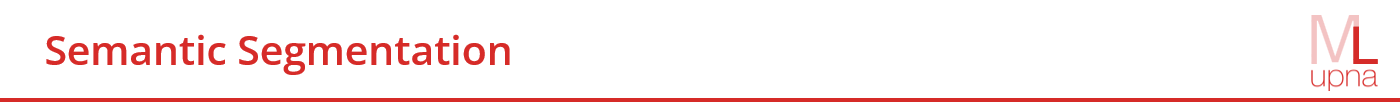

In [53]:
from collections import Counter

In [6]:
# Download from Huggingface
!wget -q --show-progress https://huggingface.co/datasets/cayala/CCP/resolve/main/clothes.zip

# Extract to folder
!unzip -q clothes.zip

# Remove the zip file
!rm clothes.zip

clothes.zip         100%[===================>]  66.20M   105MB/s    in 0.6s    


In [54]:
# Buid dataset from folder structure

from glob import glob
import pandas as pd

images = glob('./clothes/*/images/*')
df = pd.DataFrame(images, columns=['image_path'])
df['mask_path'] = df.image_path.apply(lambda x : x.replace('/images/', '/labels/').replace('.jpg', '.png'))
df['set'] = df.image_path.apply(lambda x : x.split('/')[2])
df.head()

,image_path,mask_path,set
0,./clothes/test/images/0851.jpg,./clothes/test/labels/0851.png,test
1,./clothes/test/images/0852.jpg,./clothes/test/labels/0852.png,test
2,./clothes/test/images/0853.jpg,./clothes/test/labels/0853.png,test
3,./clothes/test/images/0854.jpg,./clothes/test/labels/0854.png,test
4,./clothes/test/images/0855.jpg,./clothes/test/labels/0855.png,test


In [22]:
class_dict_df = pd.read_csv('clothes/class_dict.csv')

In [23]:
class_dict_df['array'] = class_dict_df[['r', 'g', 'b']].apply(lambda row: row.to_numpy(dtype=int), axis=1)

In [24]:
keys = class_dict_df['array'].apply(lambda x: tuple(x))
lookup = dict(zip(keys, class_dict_df['class_name']))
lookup[(np.int64(69), np.int64(6), np.int64(90))] = 'background'

total_objects = []

for path in df['mask_path'].values:
    y = imread(path)
    objects = np.unique(y.reshape(-1, y.shape[2]), axis=0)
    total_objects.extend(lookup.get(tuple(a), None) for a in objects)
    
counts = Counter(total_objects)

# Ordenar por el valor (count), de mayor a menor
sorted_counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))

df_counts = pd.DataFrame(
    list(sorted_counts.items()),
    columns=['element', 'count']
)

df_counts.to_csv("clothes/class_counts.csv", index=False)

KeyboardInterrupt: 

In [ ]:
df_counts = pd.read_csv('clothes/class_counts.csv')

plt.figure(figsize=(12, 6))

plt.bar(df_counts['element'], df_counts['count'])

plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Object Counts per Class')

plt.xticks(rotation=90)  # Para que se vean las etiquetas
plt.tight_layout()
plt.show()

In [ ]:
clustering_dict = {
    "no_clothing": [
        "background", "skin", "hair"
    ],
    "upper_wear": [
        "shirt", "t-shirt", "blouse", "top",
        "sweater", "hoodie", "sweatshirt",
        "jacket", "coat", "blazer", "cardigan",
        "vest", "cape", "jumper", "bra"
    ],
    "lower_wear": [
        "pants", "jeans", "skirt", "shorts",
        "leggings", "tights", "stockings",
        "panties"
    ],
    "one_piece_wear": [
        "dress", "romper", "bodysuit", "suit",
        "swimwear"
    ],
    "footwear": [
        "shoes", "sandals", "boots", "sneakers",
        "flats", "heels", "pumps", "wedges",
        "loafers", "socks", "clogs"
    ],
    "accessories": [
        "belt", "scarf", "hat", "gloves",
        "bag", "purse", "wallet", "accessories",
        "bracelet", "necklace", "watch",
        "ring", "earrings", "tie", "sunglasses", "glasses",
        "intimate"
    ]
}

inverse_clustering_dict = {}
for group, items in clustering_dict.items():
    for item in items:
        inverse_clustering_dict[item] = group

df_counts["cluster"] = df_counts["element"].map(inverse_clustering_dict)
df_counts.to_csv("clothes/class_counts.csv", index=False)

In [ ]:
cluster_dict_df = class_dict_df.copy().drop(columns=['r','g','b'])

cluster_dict_df.loc[0, 'class_name'] = 'background'

cluster_dict_df["cluster"] = cluster_dict_df["class_name"].map(inverse_clustering_dict)

cluster_first_array = cluster_dict_df.groupby("cluster")["array"].first().to_dict()
cluster_dict_df["cluster_array"] = cluster_dict_df["cluster"].map(cluster_first_array)

cluster_dict_df.to_csv("clothes/cluster_dict.csv", index=False)

In [ ]:
cluster_dict_df

In [ ]:
cluster_keys = cluster_dict_df['array'].apply(lambda x: tuple(x))
lookup_cluster = dict(zip(cluster_keys, cluster_dict_df['cluster']))

total_clusters = []

for path in df['mask_path'].values:
    y = imread(path)
    clusters = np.unique(y.reshape(-1, y.shape[2]), axis=0)
    total_clusters.extend((np.unique(list(lookup_cluster.get(tuple(a), None) for a in clusters))).tolist())
    
cluster_counts = Counter(total_clusters)

# Ordenar por el valor (count), de mayor a menor
sorted_cluster_counts = dict(sorted(cluster_counts.items(), key=lambda x: x[1], reverse=True))

In [ ]:
df_cluster_counts = pd.DataFrame(
    list(sorted_cluster_counts.items()),
    columns=['cluster', 'count']
)

df_cluster_counts.to_csv("clothes/cluster_counts.csv", index=False)

In [ ]:
df_cluster_counts = pd.read_csv('clothes/cluster_counts.csv')

plt.figure(figsize=(12, 6))

plt.bar(df_cluster_counts['cluster'], df_cluster_counts['count'])

plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Object Counts per Class')

plt.xticks(rotation=90)  # Para que se vean las etiquetas
plt.tight_layout()
plt.show()

In [ ]:
def read_mask(mask_path):
    y = imread(mask_path)

    clusters = np.unique(y.reshape(-1, y.shape[2]), axis=0)
    
    orig_colors = np.array([np.array(x) for x in cluster_dict_df["array"]])        # (N, 3)
    new_colors  = np.array([np.array(x) for x in cluster_dict_df["cluster_array"]]) # (N, 3)
    
    y_flat = y.reshape(-1, 3)
    
    # Matriz booleana (num_pixels x num_classes)
    matches = (y_flat[:, None, :] == orig_colors[None, :, :]).all(axis=2)
    
    # Índice del color encontrado (o -1 si ninguno)
    idx = matches.argmax(axis=1)
    mask_hit = matches.any(axis=1)
    
    y_out = y_flat.copy()
    y_out[mask_hit] = new_colors[idx[mask_hit]]
    y_out = y_out.reshape(y.shape)

    return y, y_out

In [ ]:
# Inspect a randomly taken sample
import matplotlib.pyplot as plt
from skimage.io import imread
import os
import numpy as np

r = df.sample(1).iloc[0]

x = imread(r.image_path)
y, y_out = read_mask(r.mask_path)

f, ax = plt.subplots(1, 4, figsize=(25, 5))

f.suptitle(f'Sample: {r.set} - {os.path.basename(r.image_path).split(".")[0]} ')

ax[0].imshow(x)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Image')

ax[1].imshow(y)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Mask')

ax[2].imshow(y_out)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Mask 2')

ax[3].imshow(x)
ax[3].imshow(y_out, alpha=.5)
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].set_title('Overlay')

# ax[3].imshow(x)


plt.show()

In [ ]:
np.unique(y_out.reshape(-1, y.shape[2]), axis=0)

# Imports

In [1]:
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from torch.nn import functional as F
from collections import defaultdict
from torchvision.models import ResNet18_Weights
from lightning.pytorch.loggers import CSVLogger
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms.v2 as T
import torchvision
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import os
import numpy as np
from collections import Counter
from glob import glob
import pandas as pd
from PIL import Image
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.optim.lr_scheduler import ReduceLROnPlateau
from fastprogress import master_bar, progress_bar
from sklearn.metrics import accuracy_score, jaccard_score, f1_score
N_CLASSES = 6

In [2]:
images = glob('./clothes/*/images/*')
df = pd.DataFrame(images, columns=['image_path'])
df['mask_path'] = df.image_path.apply(lambda x : x.replace('/images/', '/labels/').replace('.jpg', '.png'))
df['set'] = df.image_path.apply(lambda x : x.split('/')[2])
df.head()

,image_path,mask_path,set
0,./clothes/test/images/0851.jpg,./clothes/test/labels/0851.png,test
1,./clothes/test/images/0852.jpg,./clothes/test/labels/0852.png,test
2,./clothes/test/images/0853.jpg,./clothes/test/labels/0853.png,test
3,./clothes/test/images/0854.jpg,./clothes/test/labels/0854.png,test
4,./clothes/test/images/0855.jpg,./clothes/test/labels/0855.png,test


In [3]:
# class CustomMask():
#     def __init__(self):
#         self.cluster_dict_df = pd.read_csv("clothes/cluster_dict.csv")
#         self.orig_colors = np.array([np.fromstring(x.strip('[]'), sep=' ').astype(int) for x in self.cluster_dict_df["array"]])        # (N, 3)
#         self.new_colors  = np.array([np.fromstring(x.strip('[]'), sep=' ').astype(int) for x in self.cluster_dict_df["cluster_array"]]) # (N, 3)

#         self.cluster_counts = pd.read_csv("clothes/cluster_counts.csv")

#         self.unique_clusters_df = self.cluster_dict_df[['cluster', 'cluster_array']].drop_duplicates()
#         self.array_to_label = dict(zip(self.unique_clusters_df["cluster_array"], range(6)))

#     def read_mask(self, mask_path):
#         y = imread(mask_path)
    
#         clusters = np.unique(y.reshape(-1, y.shape[2]), axis=0)
        
#         y_flat = y.reshape(-1, 3)
        
#         # Matriz booleana (num_pixels x num_classes)
#         matches = (y_flat[:, None, :] == self.orig_colors[None, :, :]).all(axis=2)
        
#         # Índice del color encontrado (o -1 si ninguno)
#         idx = matches.argmax(axis=1)
#         mask_hit = matches.any(axis=1)
        
#         y_out = y_flat.copy()
#         y_out[mask_hit] = self.new_colors[idx[mask_hit]]
#         y_out = y_out.reshape(y.shape)
    
#         return y, y_out

#     def mask_to_labels(self, y):
#         h, w, _ = y.shape
#         y_flat = y.reshape(-1, 3)
    
#         # Convert each pixel to its string representation "[r g b]"
#         pixel_strings = np.apply_along_axis(
#             lambda row: str(row),
#             1,
#             y_flat
#         )
        
#         # Map each pixel string to its label (default -1)
#         labels = np.array([self.array_to_label.get(s, -1) for s in pixel_strings])
#         labeled_mask = labels.reshape(h, w)
        
#         return labeled_mask


In [4]:
class CustomMask:
    def __init__(self):
        df = pd.read_csv("clothes/cluster_dict.csv")
        self.cluster_counts = pd.read_csv("clothes/cluster_counts.csv")

        # Convert string "[r g b]" -> tuple (r, g, b)
        def to_tuple(s):
            return tuple(map(int, s.strip("[]").split()))

        df["orig_tuple"]   = df["array"].apply(to_tuple)
        df["new_tuple"]    = df["cluster_array"].apply(to_tuple)

        # Arrays (mantengo por si necesitas vectorización)
        self.orig_colors = np.array(df["orig_tuple"].tolist())
        self.new_colors  = np.array(df["new_tuple"].tolist())

        # Diccionarios clave para máxima velocidad
        self.map_orig_to_new = dict(zip(df["orig_tuple"], df["new_tuple"]))

        # Diccionario para labels (cluster_array → int)
        unique = df[["cluster", "cluster_array"]].drop_duplicates()
        unique["tuple"] = unique["cluster_array"].apply(to_tuple)
        self.map_tuple_to_label = {
            tpl: i for i, tpl in enumerate(unique["tuple"])
        }

    def read_mask(self, mask_path):
        y = imread(mask_path)
        h, w, _ = y.shape
        
        # Crear un array de índices únicos para cada color
        y_reshaped = y.reshape(-1, 3)
        
        # Vectorizar la búsqueda usando broadcasting
        # Comparar todos los píxeles con todos los colores originales de una vez
        matches = (y_reshaped[:, None] == self.orig_colors).all(axis=2)
        indices = np.argmax(matches, axis=1)
        
        # Aplicar la transformación
        out = np.where(matches.any(axis=1)[:, None], 
                       self.new_colors[indices], 
                       y_reshaped)
        
        return y, out.reshape(h, w, 3).astype(np.uint8)

    def mask_to_labels(self, y):
        h, w, _ = y.shape
        y_flat = y.reshape(-1, 3)
        
        # Crear array de labels correspondiente a new_colors
        label_array = np.array([self.map_tuple_to_label.get(tuple(c), -1) 
                                for c in self.new_colors])
        
        # Vectorizar la búsqueda
        matches = (y_flat[:, None] == self.new_colors).all(axis=2)
        indices = np.argmax(matches, axis=1)
        labels = np.where(matches.any(axis=1), label_array[indices], -1)
        
        return labels.reshape(h, w)

In [5]:
class CustomMaskOptimized:
    def __init__(self):
        df = pd.read_csv("clothes/cluster_dict.csv")
        self.cluster_counts = pd.read_csv("clothes/cluster_counts.csv")

        # Convert string "[r g b]" -> tuple (r, g, b)
        def to_tuple(s):
            return tuple(map(int, s.strip("[]").split()))

        df["orig_tuple"] = df["array"].apply(to_tuple)
        df["new_tuple"] = df["cluster_array"].apply(to_tuple)

        # Crear Lookup Table para conversión RGB -> cluster RGB
        self.map_orig_to_new = dict(zip(df["orig_tuple"], df["new_tuple"]))

        # Crear Lookup Table para conversión cluster RGB -> class_id
        unique = df[["cluster", "cluster_array"]].drop_duplicates()
        unique["tuple"] = unique["cluster_array"].apply(to_tuple)
        self.map_rgb_to_label = {
            tpl: i for i, tpl in enumerate(unique["tuple"])
        }
        
        # **CLAVE: Crear LUT 3D de 256x256x256**
        # Esto mapea CUALQUIER combinación RGB directamente a class_id
        print("Creando Lookup Table 3D (esto toma ~10 segundos)...")
        self.lut = np.full((256, 256, 256), -1, dtype=np.int16)
        
        # Llenar la LUT con mapeo orig_color -> new_color -> class_id
        for orig_color, new_color in self.map_orig_to_new.items():
            class_id = self.map_rgb_to_label[new_color]
            self.lut[orig_color[0], orig_color[1], orig_color[2]] = class_id
        
        # También mapear directamente los colores cluster
        for rgb, class_id in self.map_rgb_to_label.items():
            self.lut[rgb[0], rgb[1], rgb[2]] = class_id
            
        print(f"✓ Lookup Table creada. Colores mapeados: {np.sum(self.lut >= 0):,}")

    def mask_to_labels(self, mask):
        """
        Conversión ultra-rápida de máscara RGB a labels usando LUT 3D
        
        Args:
            mask: numpy array (H, W, 3) con valores RGB
            
        Returns:
            labels: numpy array (H, W) con class IDs
        """
        # Usar la máscara RGB como índices directos en la LUT
        # Esta operación es O(H*W) - extremadamente rápida
        labels = self.lut[mask[:, :, 0], mask[:, :, 1], mask[:, :, 2]]
        return labels
    
    def read_and_convert_mask(self, mask_path):
        """
        Lee y convierte máscara en un solo paso
        """
        mask = imread(mask_path)
        labels = self.mask_to_labels(mask)
        return labels

In [6]:
class CCPDataset(torch.utils.data.Dataset):

    def __init__(self, df, patch_size=224, transforms=None, mode='train'):
        super(CCPDataset, self).__init__()
        self.df = df
        self.ps = patch_size
        self.transforms = transforms
        self.mode = mode
        self.custom_mask = CustomMask()
        
    def __getitem__(self, idx):

        # Take the idx-th row from the DataFrame
        r = self.df.iloc[idx]

        # Read image and mask
        x = imread(r.image_path)
        _, y = self.custom_mask.read_mask(r.mask_path)
        y = self.custom_mask.mask_to_labels(y)
        
        # Convert into binary mask
        # y = (y != np.array([69,  6, 90])).any(-1)

        if self.mode == 'eval': # If we are evaluating (valid or test set) perform a subset based on the given coordinates
            x = x[r.coords[0]:r.coords[0]+self.ps, r.coords[1]:r.coords[1]+self.ps]
            y = y[r.coords[0]:r.coords[0]+self.ps, r.coords[1]:r.coords[1]+self.ps]
                    
        # Convert to PIL image. Converting to PIL before calling the v2 transforms makes the behavior consistent across torchvision versions.
        x = to_pil_image(x.astype('float32'))
        y = to_pil_image(y.astype('uint8'), mode='L')
        
        # Apply transforms
        if self.transforms:
            x, y = self.transforms[0](x, y) # First, transforms for both image and mask synchronized
            x = self.transforms[1](x) # Second, tranforms for only images

        # PIL to Tensor
        y = torchvision.transforms.functional.to_tensor(y).type(torch.long)
            
        return x, y

    def __show_item__(self, x, y):
        f, ax = plt.subplots(1, 3, figsize=(15, 5))

        ax[0].imshow(x.permute(1, 2, 0))
        ax[0].set_title('Image')
        ax[0].set_xticks([])
        ax[0].set_yticks([])

        ax[1].imshow(y[0])
        ax[1].set_title('Mask')
        ax[1].set_xticks([])
        ax[1].set_yticks([])

        ax[2].imshow(x.permute(1, 2, 0))
        ax[2].imshow(y[0], alpha=.5, vmin=0, vmax=1)
        ax[2].set_title('Overlay')
        ax[2].set_xticks([])
        ax[2].set_yticks([])

        plt.show()
        

    def __len__(self): 
        return self.df.shape[0]

In [7]:
class CCPDatasetLUT(torch.utils.data.Dataset):

    def __init__(self, df, patch_size=224, transforms=None, mode='train'):
        super(CCPDatasetLUT, self).__init__()
        self.df = df
        self.ps = patch_size
        self.transforms = transforms
        self.mode = mode
        
        # Crear una ÚNICA instancia de CustomMask para todo el dataset
        # La LUT se crea una sola vez y se reutiliza
        self.custom_mask = CustomMaskOptimized()
        
    def __getitem__(self, idx):
        # Take the idx-th row from the DataFrame
        r = self.df.iloc[idx]

        # Read image and mask
        x = imread(r.image_path)
        
        # Conversión ultra-rápida con LUT
        y = self.custom_mask.read_and_convert_mask(r.mask_path)
        
        if self.mode == 'eval':
            x = x[r.coords[0]:r.coords[0]+self.ps, r.coords[1]:r.coords[1]+self.ps]
            y = y[r.coords[0]:r.coords[0]+self.ps, r.coords[1]:r.coords[1]+self.ps]
                    
        # Convert to PIL image
        x = to_pil_image(x.astype('float32'))
        y = to_pil_image(y.astype('uint8'), mode='L')
        
        # Apply transforms
        if self.transforms:
            if self.transforms[0] is not None:
                x, y = self.transforms[0](x, y)
            x = self.transforms[1](x)

        # PIL to Tensor
        #y = (torchvision.transforms.functional.to_tensor(y) * 255).type(torch.long)

        y = (torchvision.transforms.functional.to_tensor(y) * 255).squeeze(0)
        y = torch.nn.functional.interpolate(
            y.unsqueeze(0).unsqueeze(0).float(),
            size=(256, 256),
            mode='nearest'
        ).squeeze(0).squeeze(0).long()
            
        return x, y

    def __show_item__(self, x, y):
        f, ax = plt.subplots(1, 3, figsize=(15, 5))

        ax[0].imshow(x.permute(1, 2, 0))
        ax[0].set_title('Image')
        ax[0].set_xticks([])
        ax[0].set_yticks([])

        ax[1].imshow(y[0])
        ax[1].set_title('Mask')
        ax[1].set_xticks([])
        ax[1].set_yticks([])

        ax[2].imshow(x.permute(1, 2, 0))
        ax[2].imshow(y[0], alpha=.5, vmin=0, vmax=1)
        ax[2].set_title('Overlay')
        ax[2].set_xticks([])
        ax[2].set_yticks([])

        plt.show()

    def __len__(self): 
        return self.df.shape[0]

In [8]:
import pytorch_lightning as pl

class DataModule(pl.LightningDataModule):
    def __init__(self, df, bs, ps, num_workers=2):
        super().__init__()
        self.df = df
        self.bs = bs
        self.ps = ps
        self.num_workers = num_workers
        
    def get_image_shape(self, path):
        with Image.open(path) as img:
            return img.size[::-1]  # (height, width)
                
    def patch_origins(self, h, w, ps, overlap=.5):
    
        if ps > h or ps > w:
            raise ValueError("Patch size ps must be <= image dimensions h and w")
    
        stride = int(ps * overlap)
        if stride <= 0:
            raise ValueError("Patch size too small")
    
        hs = list(range(0, h - ps + 1, stride))
        ws = list(range(0, w - ps + 1, stride))
    
        # make sure the last patch touches the image border
        if hs[-1] != h - ps:
            hs.append(h - ps)
        if ws[-1] != w - ps:
            ws.append(w - ps)
    
        origins = [(h, w) for h in hs for w in ws]
        return np.array(origins, dtype=int)

    def setup(self, stage): # Data preparation and transforms

        train_transforms = (
            T.Compose([
                T.RandomCrop((224, 224)),
                T.Resize(size=(256, 256)),                
            ]),
            T.Compose([
                T.ToImage(), 
                T.ToDtype(torch.float32, scale=True),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        )

        eval_transforms = (
            T.Compose([
                T.Resize(size=(256, 256)),    
            ]),
            T.Compose([
                T.ToImage(), 
                T.ToDtype(torch.float32, scale=True),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        )
        
        self.train_ds = CCPDataset(df=self.df.query('set == "train"'), patch_size=self.ps, transforms=train_transforms)

        valid_df = self.df.query('set == "valid"')

        valid_df['coords'] = valid_df.image_path.apply(
            lambda x: self.patch_origins(*self.get_image_shape(x), ps=224, overlap=1).tolist()
        )
        valid_df = valid_df.explode('coords')

        test_df = self.df.query('set == "test"')
        test_df['coords'] = test_df.image_path.apply(
            lambda x: self.patch_origins(*self.get_image_shape(x), ps=224, overlap=1).tolist()
        )
        test_df = test_df.explode('coords')
        
        self.valid_ds = CCPDataset(df=valid_df, patch_size=self.ps, transforms=eval_transforms, mode='eval')
        self.test_ds = CCPDataset(df=test_df, patch_size=self.ps, transforms=eval_transforms, mode='eval')

    def train_dataloader(self): return torch.utils.data.DataLoader(self.train_ds, batch_size=self.bs, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self): return torch.utils.data.DataLoader(self.valid_ds, batch_size=self.bs, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self): return torch.utils.data.DataLoader(self.test_ds, batch_size=self.bs, shuffle=False, num_workers=self.num_workers)
	

In [9]:
class DataModuleLUT(pl.LightningDataModule):
    def __init__(self, df, bs, ps, num_workers=2):
        super().__init__()
        self.df = df
        self.bs = bs
        self.ps = ps
        self.num_workers = num_workers
        
    def get_image_shape(self, path):
        with Image.open(path) as img:
            return img.size[::-1]  # (height, width)
                
    def patch_origins(self, h, w, ps, overlap=.5):
        if ps > h or ps > w:
            raise ValueError("Patch size ps must be <= image dimensions h and w")
    
        stride = int(ps * overlap)
        if stride <= 0:
            raise ValueError("Patch size too small")
    
        hs = list(range(0, h - ps + 1, stride))
        ws = list(range(0, w - ps + 1, stride))
    
        if hs[-1] != h - ps:
            hs.append(h - ps)
        if ws[-1] != w - ps:
            ws.append(w - ps)
    
        origins = [(h, w) for h in hs for w in ws]
        return np.array(origins, dtype=int)

    def setup(self, stage):

        """
        train_transforms = (
            T.Compose([
                T.RandomCrop((224, 224)),
                T.Resize(size=(256, 256)),                
            ]),
            T.Compose([
                T.ToImage(), 
                T.ToDtype(torch.float32, scale=True),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        )

        eval_transforms = (
            T.Compose([
                T.Resize(size=(256, 256)),    
            ]),
            T.Compose([
                T.ToImage(), 
                T.ToDtype(torch.float32, scale=True),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        )
        """

        train_transforms = (
            T.Compose([
                T.RandomCrop((224, 224))
            ]),
            T.Compose([
                T.Resize(size=(256, 256)),
                T.ToImage(), 
                T.ToDtype(torch.float32, scale=True),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        )

        eval_transforms = (
            None,
            T.Compose([
                T.Resize(size=(256, 256)),
                T.ToImage(), 
                T.ToDtype(torch.float32, scale=True),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        )
        
        self.train_ds = CCPDatasetLUT(
            df=self.df.query('set == "train"'), 
            patch_size=self.ps, 
            transforms=train_transforms
        )

        valid_df = self.df.query('set == "valid"')
        valid_df['coords'] = valid_df.image_path.apply(
            lambda x: self.patch_origins(*self.get_image_shape(x), ps=224, overlap=1).tolist()
        )
        valid_df = valid_df.explode('coords')

        test_df = self.df.query('set == "test"')
        test_df['coords'] = test_df.image_path.apply(
            lambda x: self.patch_origins(*self.get_image_shape(x), ps=224, overlap=1).tolist()
        )
        test_df = test_df.explode('coords')
        
        self.valid_ds = CCPDatasetLUT(
            df=valid_df, 
            patch_size=self.ps, 
            transforms=eval_transforms, 
            mode='eval'
        )
        self.test_ds = CCPDatasetLUT(
            df=test_df, 
            patch_size=self.ps, 
            transforms=eval_transforms, 
            mode='eval'
        )

    def train_dataloader(self): 
        return torch.utils.data.DataLoader(
            self.train_ds, 
            batch_size=self.bs, 
            shuffle=True, 
            num_workers=self.num_workers
        )

    def val_dataloader(self): 
        return torch.utils.data.DataLoader(
            self.valid_ds, 
            batch_size=self.bs, 
            shuffle=False, 
            num_workers=self.num_workers
        )

    def test_dataloader(self): 
        return torch.utils.data.DataLoader(
            self.test_ds, 
            batch_size=self.bs, 
            shuffle=False, 
            num_workers=self.num_workers
        )

In [10]:
class LightningModule(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.save_hyperparameters()
        
        # Creating model
        self.model = model

        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)
        
    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

        # Configure ReduceLROnPlateau scheduler
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',           # Minimize the monitored metric
            factor=0.1,          # Multiply LR by this factor when reducing
            patience=5,          # Number of epochs with no improvement before reducing LR
            threshold=0.01,      # Threshold for measuring improvement
            threshold_mode='rel', # 'rel' for relative change, 'abs' for absolute
            cooldown=0,          # Number of epochs to wait before resuming normal operation
            min_lr=1e-6,         # Lower bound on the learning rate
            eps=1e-8             # Minimal decay applied to lr
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',  # Metric to monitor
                'interval': 'epoch',     # Update scheduler after each epoch
                'frequency': 1,          # Check metric every epoch
                'strict': True,          # Enforce that monitored metric exists
            }
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y.squeeze(1)) # y: (BS, 1, H, W) -> (BS, H, W)
        
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.training_step_outputs['loss'] += loss.detach().cpu()
        self.training_step_outputs['steps'] += 1
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y.squeeze(1))
        
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.validation_step_outputs['loss'] += loss.detach().cpu()
        self.validation_step_outputs['steps'] += 1
        
        return loss

    def on_train_epoch_end(self): 
        avg_loss = self.training_step_outputs['loss'] / self.training_step_outputs['steps']
        print(f"Average training loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.training_step_outputs.clear() 

    def on_validation_epoch_end(self):
        avg_loss = self.validation_step_outputs['loss'] / self.validation_step_outputs['steps']
        print(f"Average validation loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.validation_step_outputs.clear() 

In [23]:
# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

model = smp.Segformer(
    encoder_name='resnet18',
    encoder_weights='imagenet',
    in_channels=3,
    classes=N_CLASSES
)

# Intantiate LightningModule
lightning_module = LightningModule(model)

# Define a CSV logger to store training/validation metrics in CSV format.
csv_logger = CSVLogger(save_dir=os.getcwd(), name="ccp_segformer")

# Define a checkpoint callback:
# It will save the model with the lowest validation loss ("best_valid_loss.ckpt").
model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',mode='min', filename='best_valid_loss', verbose=True, save_last=False)
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=10,
    verbose=False,
    mode="min"
)
# Create a PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=100, logger=csv_logger, callbacks=[early_stop_callback, model_checkpoint_callback])

# Load the data module
data_module = DataModuleLUT(df, bs=32, ps=224, num_workers=4)

# Train the model with the trainer, passing the core LightningModule and data module.
trainer.fit(lightning_module, data_module)

Seed set to 42
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/parsing.py:210: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Creando Lookup Table 3D (esto toma ~10 segundos)...
✓ Lookup Table creada. Colores mapeados: 59


/tmp/ipykernel_280254/3085135990.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['coords'] = valid_df.image_path.apply(
/tmp/ipykernel_280254/3085135990.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['coords'] = test_df.image_path.apply(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | Segformer | 11.8 M | train
--------------------------------------------
11.8 M    Trainable params
0       

Creando Lookup Table 3D (esto toma ~10 segundos)...
✓ Lookup Table creada. Colores mapeados: 59
Creando Lookup Table 3D (esto toma ~10 segundos)...
✓ Lookup Table creada. Colores mapeados: 59


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Average validation loss for epoch 0: 1.8628


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 0, global step 22: 'val_loss' reached 2.20049 (best 2.20049), saving model to '/home/alumno/Desktop/datos/Computer Vision/Assignment 06/clothing-co-parsing/ccp_segformer/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 0: 2.1837
Average training loss for epoch 0: 0.9800


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 1, global step 44: 'val_loss' reached 0.42842 (best 0.42842), saving model to '/home/alumno/Desktop/datos/Computer Vision/Assignment 06/clothing-co-parsing/ccp_segformer/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 1: 0.4278
Average training loss for epoch 1: 0.7065


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 2, global step 66: 'val_loss' reached 0.33120 (best 0.33120), saving model to '/home/alumno/Desktop/datos/Computer Vision/Assignment 06/clothing-co-parsing/ccp_segformer/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 2: 0.3299
Average training loss for epoch 2: 0.5724


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 3, global step 88: 'val_loss' was not in top 1


Average validation loss for epoch 3: 0.4503
Average training loss for epoch 3: 0.5228


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 4, global step 110: 'val_loss' was not in top 1


Average validation loss for epoch 4: 0.3486
Average training loss for epoch 4: 0.5355


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 5, global step 132: 'val_loss' reached 0.29741 (best 0.29741), saving model to '/home/alumno/Desktop/datos/Computer Vision/Assignment 06/clothing-co-parsing/ccp_segformer/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 5: 0.2976
Average training loss for epoch 5: 0.5309


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 6, global step 154: 'val_loss' was not in top 1


Average validation loss for epoch 6: 0.3295
Average training loss for epoch 6: 0.4938


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 7, global step 176: 'val_loss' reached 0.27192 (best 0.27192), saving model to '/home/alumno/Desktop/datos/Computer Vision/Assignment 06/clothing-co-parsing/ccp_segformer/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 7: 0.2713
Average training loss for epoch 7: 0.4617


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 8, global step 198: 'val_loss' was not in top 1


Average validation loss for epoch 8: 0.2883
Average training loss for epoch 8: 0.4422


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 9, global step 220: 'val_loss' was not in top 1


Average validation loss for epoch 9: 0.2773
Average training loss for epoch 9: 0.4360


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 10, global step 242: 'val_loss' was not in top 1


Average validation loss for epoch 10: 0.3259
Average training loss for epoch 10: 0.4297


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 11, global step 264: 'val_loss' was not in top 1


Average validation loss for epoch 11: 0.3156
Average training loss for epoch 11: 0.4390


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 12, global step 286: 'val_loss' was not in top 1


Average validation loss for epoch 12: 0.2732
Average training loss for epoch 12: 0.4441


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 13, global step 308: 'val_loss' reached 0.26238 (best 0.26238), saving model to '/home/alumno/Desktop/datos/Computer Vision/Assignment 06/clothing-co-parsing/ccp_segformer/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 13: 0.2623
Average training loss for epoch 13: 0.4166


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 14, global step 330: 'val_loss' was not in top 1


Average validation loss for epoch 14: 0.2713
Average training loss for epoch 14: 0.4005


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 15, global step 352: 'val_loss' was not in top 1


Average validation loss for epoch 15: 0.2807
Average training loss for epoch 15: 0.3912


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 16, global step 374: 'val_loss' was not in top 1


Average validation loss for epoch 16: 0.2890
Average training loss for epoch 16: 0.3945


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 17, global step 396: 'val_loss' was not in top 1


Average validation loss for epoch 17: 0.2888
Average training loss for epoch 17: 0.4058


   epoch  step  train_loss  val_loss
0      0    21    0.980478  2.200492
1      1    43    0.706722  0.428424
2      2    65    0.572742  0.331199
3      3    87    0.522740  0.452548
4      4   109    0.535653  0.347290


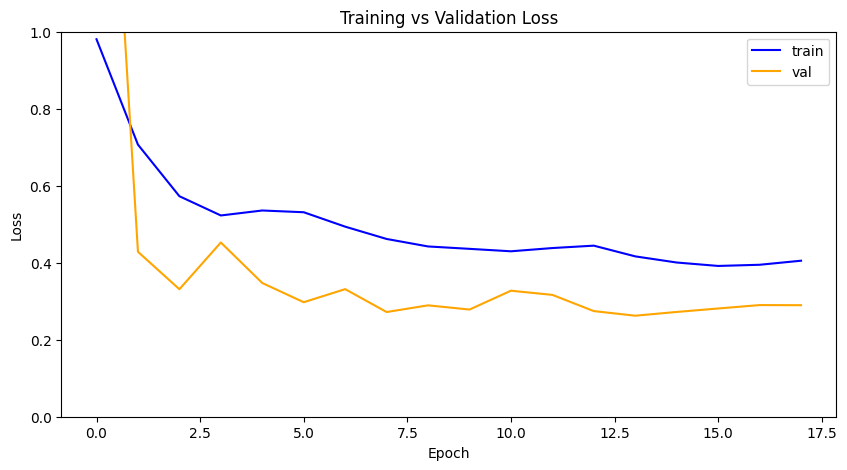

In [24]:
#metric_df = pd.read_csv("/home/alumno/Desktop/datos/Computer Vision/Assignment 06/clothing-co-parsing/ccp_unet/version_5/metrics.csv")
metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first()
print(metric_df.head())

f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.set_ylim((0, 1))
ax.legend()
plt.savefig("./figures/segformer_losses.pdf", dpi=80)
plt.show()

In [13]:
pl.seed_everything(seed=42, workers=True)

model = smp.Unet(
    encoder_name='resnet18',
    encoder_weights='imagenet',
    in_channels=3,
    classes=N_CLASSES
)

model = LightningModule.load_from_checkpoint("/home/alumno/Desktop/datos/COMPUTER_VISION/ASSIGNMENT_3/clothing-co-parsing/ccp_unet/version_5/checkpoints/best_valid_loss.ckpt", model=model)
#model = LightningModule.load_from_checkpoint(model_checkpoint_callback.best_model_path, model=model)
model.cuda(0)
model.eval()

import torch.nn as nn

ps = 256

inf_transforms = T.Compose([
    T.ToImage(), 
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

metric_dict = []
test_df = df.query('set == "test"')

mb = master_bar(test_df.iterrows(), total=test_df.shape[0])
cm = CustomMaskOptimized()  # Usar versión optimizada

for i, r in mb:
    # Read image and mask
    x = imread(r.image_path)
    
    # Conversión ultra-rápida con LUT
    y = cm.read_and_convert_mask(r.mask_path)

    # Compute origins
    h, w = y.shape
    coords = DataModuleLUT.patch_origins(None, h, w, ps=ps, overlap=1).tolist()

    # Initialize y_hat
    y_hat = torch.zeros((N_CLASSES, h, w), dtype=torch.float32)
    y_wei = torch.zeros((1, h, w), dtype=torch.uint8)
    
    # Perform inference
    for (coord_x, coord_y) in progress_bar(coords, parent=mb):
        xi = x[coord_x:coord_x+ps, coord_y:coord_y+ps]
        xi = to_pil_image(xi.astype('float32'))
        xi = inf_transforms(xi)

        with torch.no_grad():
            logits = model(xi.cuda(0).unsqueeze(0))
            logits = nn.Softmax(1)(logits).detach().cpu()[0]
        
        actual_h = min(ps, h - coord_x)
        actual_w = min(ps, w - coord_y)
        
        y_hat[:, coord_x:coord_x+actual_h, coord_y:coord_y+actual_w] += logits[:, :actual_h, :actual_w]
        y_wei[:, coord_x:coord_x+actual_h, coord_y:coord_y+actual_w] += 1

    y_hat /= y_wei
    y_hat_bin = y_hat.argmax(0)

    metric_dict.append({
        'pixel_acc': accuracy_score(y_hat_bin.ravel(), y.ravel()),
        'iou': jaccard_score(y_hat_bin.ravel(), y.ravel(), average='macro'),
        'dice': f1_score(y_hat_bin.ravel(), y.ravel(), average='macro')
    })

pd.DataFrame.from_records(metric_dict).mean(0)

Seed set to 42


Creando Lookup Table 3D (esto toma ~10 segundos)...
✓ Lookup Table creada. Colores mapeados: 59


pixel_acc    0.912793
iou          0.482816
dice         0.555345
dtype: float64

In [25]:
model = LightningModule.load_from_checkpoint(model_checkpoint_callback.best_model_path, model=model)
"""
model = LightningModule.load_from_checkpoint(
    "/home/alumno/Desktop/datos/Computer Vision/Assignment 06/clothing-co-parsing/ccp_unet/version_5/checkpoints/best_valid_loss.ckpt"
)
"""
model.cuda(0)
model.eval()

import torch.nn as nn
from sklearn.metrics import accuracy_score, jaccard_score, f1_score

ps = 256
inf_transforms = T.Compose([
    T.ToImage(), 
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

metric_dict = []
test_df = df.query('set == "test"')
mb = master_bar(test_df.iterrows(), total=test_df.shape[0])
cm_model = CustomMaskOptimized()

for i, r in mb:
    x = imread(r.image_path)
    y = cm_model.read_and_convert_mask(r.mask_path)
    
    h, w = y.shape
    coords = DataModuleLUT.patch_origins(None, h, w, ps=ps, overlap=1).tolist()
    
    y_hat = torch.zeros((N_CLASSES, h, w), dtype=torch.float32)
    y_wei = torch.zeros((1, h, w), dtype=torch.uint8)
    
    for (coord_x, coord_y) in progress_bar(coords, parent=mb):
        xi = x[coord_x:coord_x+ps, coord_y:coord_y+ps]
        xi = to_pil_image(xi.astype('float32'))
        xi = inf_transforms(xi)
        with torch.no_grad():
            logits = model(xi.cuda(0).unsqueeze(0))
            logits = nn.Softmax(1)(logits).detach().cpu()[0]
        
        actual_h = min(ps, h - coord_x)
        actual_w = min(ps, w - coord_y)
        
        y_hat[:, coord_x:coord_x+actual_h, coord_y:coord_y+actual_w] += logits[:, :actual_h, :actual_w]
        y_wei[:, coord_x:coord_x+actual_h, coord_y:coord_y+actual_w] += 1
    
    y_hat /= y_wei
    y_hat_bin = y_hat.argmax(0)
    
    y_pred_flat = y_hat_bin.ravel()
    y_true_flat = y.ravel()
    
    # Métricas globales
    metrics = {
        'pixel_acc': accuracy_score(y_true_flat, y_pred_flat),
        'iou_macro': jaccard_score(y_true_flat, y_pred_flat, average='macro', zero_division=0),
        'dice_macro': f1_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
    }
    
    # Métricas por clase con labels explícitos para incluir TODAS las clases
    iou_per_class = jaccard_score(
        y_true_flat, 
        y_pred_flat, 
        average=None, 
        labels=list(range(N_CLASSES)),  # ← CLAVE: especificar todas las clases
        zero_division=0
    )
    dice_per_class = f1_score(
        y_true_flat, 
        y_pred_flat, 
        average=None, 
        labels=list(range(N_CLASSES)),  # ← CLAVE: especificar todas las clases
        zero_division=0
    )
    
    # Ahora iou_per_class y dice_per_class siempre tendrán N_CLASSES elementos
    for class_idx in range(N_CLASSES):
        metrics[f'iou_class_{class_idx}'] = iou_per_class[class_idx]
        metrics[f'dice_class_{class_idx}'] = dice_per_class[class_idx]
    
    metric_dict.append(metrics)

# Crear DataFrame con resultados
results_df = pd.DataFrame.from_records(metric_dict)

# Métricas globales
print("=" * 60)
print("MÉTRICAS GLOBALES (promedio en test set)")
print("=" * 60)
global_metrics = results_df[['pixel_acc', 'iou_macro', 'dice_macro']].mean()
print(global_metrics)
print()

# Métricas por clase
print("=" * 60)
print("MÉTRICAS POR CLASE (promedio en test set)")
print("=" * 60)
class_metrics = pd.DataFrame({
    'Class': range(N_CLASSES),
    'IoU': [results_df[f'iou_class_{class_idx}'].mean() for class_idx in range(N_CLASSES)],
    'Dice': [results_df[f'dice_class_{class_idx}'].mean() for class_idx in range(N_CLASSES)],
    'Std_IoU': [results_df[f'iou_class_{class_idx}'].std() for class_idx in range(N_CLASSES)],
    'Std_Dice': [results_df[f'dice_class_{class_idx}'].std() for class_idx in range(N_CLASSES)]
})
print(class_metrics.to_string(index=False))
print()

# Guardar resultados
results_df.to_csv('test_metrics_detailed_segformer.csv', index=False)
print("Resultados guardados en 'test_metrics_detailed_segformer.csv'")

Creando Lookup Table 3D (esto toma ~10 segundos)...
✓ Lookup Table creada. Colores mapeados: 59


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/parsing.py:210: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


MÉTRICAS GLOBALES (promedio en test set)
pixel_acc     0.901348
iou_macro     0.439118
dice_macro    0.513290
dtype: float64

MÉTRICAS POR CLASE (promedio en test set)
 Class      IoU     Dice  Std_IoU  Std_Dice
     0 0.948233 0.972802 0.046114  0.026713
     1 0.141418 0.198385 0.212653  0.269725
     2 0.486888 0.596377 0.285352  0.311494
     3 0.124364 0.177076 0.196523  0.257164
     4 0.541002 0.662154 0.250411  0.251537
     5 0.355433 0.431262 0.337354  0.380958

Resultados guardados en 'test_metrics_detailed_segformer.csv'


We will now load the best model and perform inference as before, in order to compute metrics and compare this approach with the previous ones.

In [39]:
# Load the best model
model = LightningModule.load_from_checkpoint(model_checkpoint_callback.best_model_path, model=model)
model.cuda(0) # Move to GPU
model.eval()

LightningModule(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1):

In [47]:
# Load the best model
model = LightningModule.load_from_checkpoint("/home/alumno/Desktop/datos/COMPUTER_VISION/ASSIGNMENT_3/clothing-co-parsing/ccp_unet/version_5/checkpoints/best_valid_loss.ckpt", model=model)
model.cuda(0) # Move to GPU
model.eval()

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/parsing.py:210: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


LightningModule(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1):

In [48]:
import torch.nn as nn
from sklearn.metrics import accuracy_score, jaccard_score, f1_score

In [49]:
ps = 256 # Imagenet Resizes to 256

inf_transforms = T.Compose([
    # T.Resize(size=(256, 256)),    
    T.ToImage(), 
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

metric_dict = []

test_df = df.query('set == "test"')

mb = master_bar(test_df.iterrows(), total=test_df.shape[0])
cm = CustomMask()

for i, r in mb:

    # Read image and mask
    x = imread(r.image_path)
    y = imread(r.mask_path)
    
    # Convert into label mask
    _, y = cm.read_mask(r.mask_path)
    y = cm.mask_to_labels(y)

    # Compute origins
    h, w = y.shape
    coords = DataModule.patch_origins(None, h, w, ps=ps, overlap=1).tolist()

    # Initialize y_hat
    y_hat = torch.zeros((N_CLASSES, h, w), dtype=torch.float32)
    y_wei = torch.zeros((1, h, w), dtype=torch.uint8) # Times each pixel has been infered
    
    # Perform inference
    for (coord_x, coord_y) in progress_bar(coords, parent=mb):
            
        # Crop
        xi = x[coord_x:coord_x+ps, coord_y:coord_y+ps]
        
        # Convert to PIL image.
        xi = to_pil_image(xi.astype('float32'))
        
        # Apply transforms
        xi = inf_transforms(xi)

        # Forward
        with torch.no_grad():
            logits = model(xi.cuda(0).unsqueeze(0))
            logits = nn.Softmax(1)(logits).detach().cpu()[0]

        # Store predictions
        y_hat[:, coord_x:coord_x+ps, coord_y:coord_y+ps] += logits
        y_wei[:, coord_x:coord_x+ps, coord_y:coord_y+ps] += 1

    # Normalize logits and gen binary mask
    y_hat /= y_wei
    y_hat_bin = y_hat.argmax(0)

    # Compute metrics
    metric_dict.append({
        'pixel_acc': accuracy_score(y_hat_bin.ravel(), y.ravel()),
        'iou': jaccard_score(y_hat_bin.ravel(), y.ravel(), average='weighted'),
        'dice': f1_score(y_hat_bin.ravel(), y.ravel(), average='weighted')
    })
    break

In [50]:
xi = x[400:624, 150:150+224]
xi = to_pil_image(xi.astype('float32'))
xi = inf_transforms(xi)
with torch.no_grad():
    logits = model(xi.cuda(0).unsqueeze(0))
logits.argmax(1)[0].unique()

tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1], device='cuda:0')

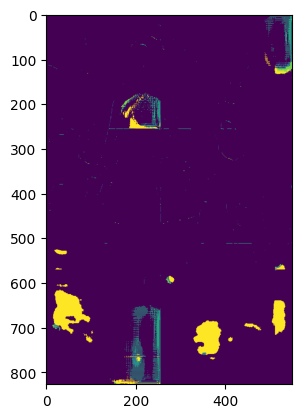

In [51]:
plt.imshow(y_hat.argmax(0))

In [82]:
ps = 256 # Imagenet Resizes to 256

inf_transforms = T.Compose([
    # T.Resize(size=(256, 256)),    
    T.ToImage(), 
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

metric_dict = []

test_df = df.query('set == "test"')

mb = master_bar(test_df.iterrows(), total=test_df.shape[0])
cm = CustomMask()

for i, r in mb:

    # Read image and mask
    x = imread(r.image_path)
    y = imread(r.mask_path)
    
    # Convert into label mask
    _, y = cm.read_mask(r.mask_path)
    y = cm.mask_to_labels(y)

    # Compute origins
    h, w = y.shape
    coords = DataModule.patch_origins(None, h, w, ps=ps, overlap=1).tolist()

    # Initialize y_hat
    y_hat = torch.zeros((N_CLASSES, h, w), dtype=torch.float32)
    y_wei = torch.zeros((1, h, w), dtype=torch.uint8) # Times each pixel has been infered
    
    # Perform inference
    for (coord_x, coord_y) in progress_bar(coords, parent=mb):
            
        # Crop
        xi = x[coord_x:coord_x+ps, coord_y:coord_y+ps]
        
        # Convert to PIL image.
        xi = to_pil_image(xi.astype('float32'))
        
        # Apply transforms
        xi = inf_transforms(xi)

        # Forward
        with torch.no_grad():
            logits = model(xi.cuda(0).unsqueeze(0))
            logits = nn.Softmax(1)(logits).detach().cpu()[0]
        
        # Calcular el tamaño real del slice
        actual_h = min(ps, h - coord_x)
        actual_w = min(ps, w - coord_y)
        
        # Store predictions (solo la parte válida)
        y_hat[:, coord_x:coord_x+actual_h, coord_y:coord_y+actual_w] += logits[:, :actual_h, :actual_w]
        y_wei[:, coord_x:coord_x+actual_h, coord_y:coord_y+actual_w] += 1

    # Normalize logits and gen binary mask
    y_hat /= y_wei
    y_hat_bin = y_hat.argmax(0)

    # Compute metrics
    metric_dict.append({
        'pixel_acc': accuracy_score(y_hat_bin.ravel(), y.ravel()),
        'iou': jaccard_score(y_hat_bin.ravel(), y.ravel(), average='macro'),
        'dice': f1_score(y_hat_bin.ravel(), y.ravel(), average='macro')
    })

In [81]:
y_wei.max()

tensor(4, dtype=torch.uint8)

In [ ]:
with torch.no_grad():
    logits = model(xi.cuda(0).unsqueeze(0))
    logits = nn.Softmax(1)(logits).detach().cpu()[0]

In [85]:
pd.DataFrame.from_records(metric_dict).mean(0)

pixel_acc    0.796916
iou          0.770199
dice         0.796897
dtype: float64

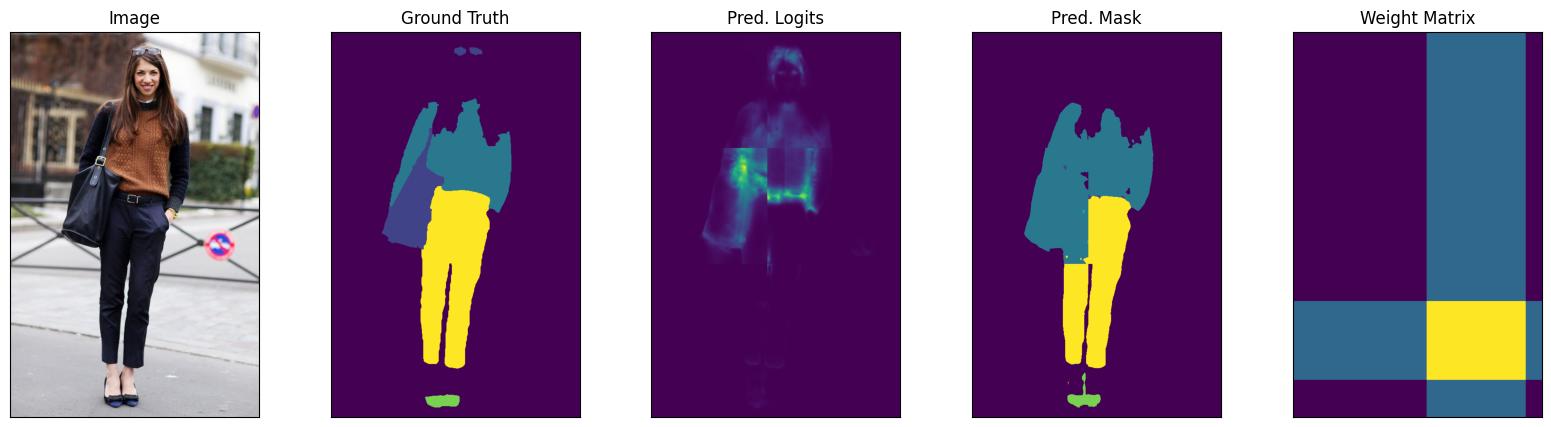

In [26]:
f, ax = plt.subplots(1, 5, figsize=(20, 5))

ax[0].imshow(x)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Image')

ax[1].imshow(y)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Ground Truth')

ax[2].imshow(y_hat[1])
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Pred. Logits')

ax[3].imshow(y_hat_bin)
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].set_title('Pred. Mask')

ax[4].imshow(y_wei[0])
ax[4].set_xticks([])
ax[4].set_yticks([])
ax[4].set_title('Weight Matrix')

plt.savefig("./figures/segformer_test_pred.pdf", dpi=80)
plt.show()

# TTA

In [42]:
import ttach as tta

# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

model = smp.Unet(
    encoder_name='resnet18',
    encoder_weights='imagenet',
    in_channels=3,
    classes=N_CLASSES
)

# Intantiate LightningModule
lightning_module = LightningModule(model)

# Define a CSV logger to store training/validation metrics in CSV format.
csv_logger = CSVLogger(save_dir=os.getcwd(), name="ccp_unet")

# Define a checkpoint callback:
# It will save the model with the lowest validation loss ("best_valid_loss.ckpt").
model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',mode='min', filename='best_valid_loss', verbose=True, save_last=False)

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=10,
    verbose=False,
    mode="min"
)
# Create a PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=100, logger=csv_logger, callbacks=[early_stop_callback, model_checkpoint_callback])

# Load the data module
data_module = DataModuleLUT(df, bs=32, ps=224, num_workers=4)

# Cargar modelo
model = LightningModule.load_from_checkpoint(
    "/home/alumno/Desktop/datos/COMPUTER_VISION/ASSIGNMENT_3/clothing-co-parsing/ccp_unet/version_5/checkpoints/best_valid_loss.ckpt"
)
model.cuda(0)
model.eval()

# Configurar TTA - estas son las transformaciones más comunes para segmentación
tta_transforms = tta.Compose([
    tta.HorizontalFlip(),
    # tta.Add(values=[0]),#tta.Add(values=[0, 5, 10, 20]),
    # tta.Multiply(factors=[1.0]) #tta.Multiply(factors=[0.9, 1.0, 1.1])
])

# Envolver el modelo con TTA
# IMPORTANTE: Acceder al modelo interno de LightningModule
tta_model = tta.SegmentationTTAWrapper(model.model, tta_transforms, merge_mode='mean')
tta_model.cuda(0)
tta_model.eval()

print(f"✓ TTA configurado con {len(tta_transforms)} transformaciones")

Seed set to 42
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/parsing.py:210: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


✓ TTA configurado con 2 transformaciones


In [43]:
ps = 256

inf_transforms = T.Compose([
    T.ToImage(), 
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

metric_dict = []
test_df = df.query('set == "test"')
mb = master_bar(test_df.iterrows(), total=test_df.shape[0])
cm_model = CustomMaskOptimized()

for i, r in mb:
    x = imread(r.image_path)
    y = cm_model.read_and_convert_mask(r.mask_path)
    
    h, w = y.shape
    coords = DataModuleLUT.patch_origins(None, h, w, ps=ps, overlap=1).tolist()
    
    y_hat = torch.zeros((N_CLASSES, h, w), dtype=torch.float32)
    y_wei = torch.zeros((1, h, w), dtype=torch.uint8)
    
    for (coord_x, coord_y) in progress_bar(coords, parent=mb):
        # Crop
        xi = x[coord_x:coord_x+ps, coord_y:coord_y+ps]
        
        # Convert to PIL image.
        xi = to_pil_image(xi.astype('float32'))
        
        # Apply transforms
        xi = inf_transforms(xi)

        # Forward
        with torch.no_grad():
            # logits = model(xi.cuda(0).unsqueeze(0))
            # logits = nn.Softmax(1)(logits).detach().cpu()[0]
            
            # TTA model expects input on GPU
            logits = tta_model(xi.cuda(0).unsqueeze(0))
            # TTA wrapper already applies softmax and merges, so just detach
            logits = logits.detach().cpu()[0]
        
        # Calcular el tamaño real del slice
        actual_h = min(ps, h - coord_x)
        actual_w = min(ps, w - coord_y)
        
        # Store predictions (solo la parte válida)
        y_hat[:, coord_x:coord_x+actual_h, coord_y:coord_y+actual_w] += logits[:, :actual_h, :actual_w]
        y_wei[:, coord_x:coord_x+actual_h, coord_y:coord_y+actual_w] += 1
    
    y_hat /= y_wei
    y_hat_bin = y_hat.argmax(0)
    
    y_pred_flat = y_hat_bin.ravel()
    y_true_flat = y.ravel()
    
    # Métricas globales
    metrics = {
        'pixel_acc': accuracy_score(y_true_flat, y_pred_flat),
        'iou_macro': jaccard_score(y_true_flat, y_pred_flat, average='macro', zero_division=0),
        'dice_macro': f1_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
    }
    
    # Métricas por clase
    iou_per_class = jaccard_score(
        y_true_flat, 
        y_pred_flat, 
        average=None, 
        labels=list(range(N_CLASSES)),
        zero_division=0
    )
    dice_per_class = f1_score(
        y_true_flat, 
        y_pred_flat, 
        average=None, 
        labels=list(range(N_CLASSES)),
        zero_division=0
    )
    
    for class_idx in range(N_CLASSES):
        metrics[f'iou_class_{class_idx}'] = iou_per_class[class_idx]
        metrics[f'dice_class_{class_idx}'] = dice_per_class[class_idx]
    
    metric_dict.append(metrics)

print("\n✓ Inferencia con TTA completada")

Creando Lookup Table 3D (esto toma ~10 segundos)...
✓ Lookup Table creada. Colores mapeados: 59



✓ Inferencia con TTA completada


In [45]:
# Crear DataFrame con resultados
results_df = pd.DataFrame.from_records(metric_dict)

# Métricas globales
print("=" * 60)
print("GLOBAL METRICS WITH TTA (mean applied in test set)")
print("=" * 60)
global_metrics = results_df[['pixel_acc', 'iou_macro', 'dice_macro']].mean()
global_std = results_df[['pixel_acc', 'iou_macro', 'dice_macro']].std()

print("\nPromedio:")
print(global_metrics)
print("\nDesviación estándar:")
print(global_std)
print()

# Métricas por clase
print("=" * 60)
print("METRICS PER CLASS WITH TTA (mean applied in test set)")
print("=" * 60)
class_metrics = pd.DataFrame({
    'Class': range(N_CLASSES),
    'IoU_mean': [results_df[f'iou_class_{class_idx}'].mean() for class_idx in range(N_CLASSES)],
    'IoU_std': [results_df[f'iou_class_{class_idx}'].std() for class_idx in range(N_CLASSES)],
    'Dice_mean': [results_df[f'dice_class_{class_idx}'].mean() for class_idx in range(N_CLASSES)],
    'Dice_std': [results_df[f'dice_class_{class_idx}'].std() for class_idx in range(N_CLASSES)]
})
print(class_metrics.to_string(index=False))
print()

# Guardar resultados
results_df.to_csv('test_metrics_with_TTA.csv', index=False)
class_metrics.to_csv('test_metrics_by_class_TTA.csv', index=False)

print("✓ Saved results:")
print("  - test_metrics_with_TTA.csv")
print("  - test_metrics_by_class_TTA.csv")

GLOBAL METRICS WITH TTA (mean applied in test set)

Promedio:
pixel_acc     0.914365
iou_macro     0.486993
dice_macro    0.559290
dtype: float64

Desviación estándar:
pixel_acc     0.053485
iou_macro     0.112387
dice_macro    0.114010
dtype: float64

METRICS PER CLASS WITH TTA (mean applied in test set)
 Class  IoU_mean  IoU_std  Dice_mean  Dice_std
     0  0.964844 0.040590   0.981633  0.023154
     1  0.240038 0.239083   0.332759  0.287472
     2  0.555317 0.314874   0.648990  0.328338
     3  0.126183 0.221261   0.170652  0.276451
     4  0.608691 0.229213   0.725661  0.223407
     5  0.413557 0.368316   0.481740  0.403485

✓ Saved results:
  - test_metrics_with_TTA.csv
  - test_metrics_by_class_TTA.csv


In [ ]:
def evaluate_model(model_wrapper, model_name, use_tta=False):
    """
    Función helper para evaluar con o sin TTA
    """
    metric_dict = []
    test_df = df.query('set == "test"')
    mb = master_bar(test_df.iterrows(), total=test_df.shape[0])
    cm_model = CustomMaskOptimized()
    
    for i, r in mb:
        x = imread(r.image_path)
        y = cm_model.read_and_convert_mask(r.mask_path)
        
        h, w = y.shape
        coords = DataModuleLUT.patch_origins(None, h, w, ps=256, overlap=1).tolist()
        
        y_hat = torch.zeros((N_CLASSES, h, w), dtype=torch.float32)
        y_wei = torch.zeros((1, h, w), dtype=torch.uint8)
        
        for (coord_x, coord_y) in progress_bar(coords, parent=mb):
            xi = x[coord_x:coord_x+256, coord_y:coord_y+256]
            xi = to_pil_image(xi.astype('float32'))
            xi = inf_transforms(xi)
            
            with torch.no_grad():
                logits = model_wrapper(xi.cuda(0).unsqueeze(0))
                logits = nn.Softmax(1)(logits).detach().cpu()[0]
            
            actual_h = min(256, h - coord_x)
            actual_w = min(256, w - coord_y)
            
            y_hat[:, coord_x:coord_x+actual_h, coord_y:coord_y+actual_w] += logits[:, :actual_h, :actual_w]
            y_wei[:, coord_x:coord_x+actual_h, coord_y:coord_y+actual_w] += 1
        
        y_hat /= y_wei
        y_hat_bin = y_hat.argmax(0)
        
        y_pred_flat = y_hat_bin.ravel()
        y_true_flat = y.ravel()
        
        metrics = {
            'pixel_acc': accuracy_score(y_true_flat, y_pred_flat),
            'iou_macro': jaccard_score(y_true_flat, y_pred_flat, average='macro', zero_division=0),
            'dice_macro': f1_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
        }
        
        metric_dict.append(metrics)
    
    results_df = pd.DataFrame.from_records(metric_dict)
    
    print(f"\n{'='*60}")
    print(f"RESULTADOS - {model_name}")
    print(f"{'='*60}")
    print(results_df[['pixel_acc', 'iou_macro', 'dice_macro']].mean())
    
    return results_df

# Evaluar SIN TTA
print("Evaluando SIN TTA...")
results_no_tta = evaluate_model(model.model, "Sin TTA", use_tta=False)

# Evaluar CON TTA
print("\nEvaluando CON TTA...")
results_with_tta = evaluate_model(tta_model, "Con TTA", use_tta=True)

# Comparación
print("\n" + "="*60)
print("COMPARACIÓN TTA vs NO-TTA")
print("="*60)
comparison = pd.DataFrame({
    'Metric': ['Pixel Accuracy', 'IoU (macro)', 'Dice (macro)'],
    'Sin TTA': [
        results_no_tta['pixel_acc'].mean(),
        results_no_tta['iou_macro'].mean(),
        results_no_tta['dice_macro'].mean()
    ],
    'Con TTA': [
        results_with_tta['pixel_acc'].mean(),
        results_with_tta['iou_macro'].mean(),
        results_with_tta['dice_macro'].mean()
    ]
})
comparison['Mejora (%)'] = ((comparison['Con TTA'] - comparison['Sin TTA']) / comparison['Sin TTA'] * 100)
print(comparison.to_string(index=False))

In [ ]:
# Visualizar predicción con TTA en una imagen de test
test_sample = test_df.iloc[0]

x = imread(test_sample.image_path)
y = cm_model.read_and_convert_mask(test_sample.mask_path)

h, w = y.shape
coords = DataModuleLUT.patch_origins(None, h, w, ps=256, overlap=1).tolist()

y_hat = torch.zeros((N_CLASSES, h, w), dtype=torch.float32)
y_wei = torch.zeros((1, h, w), dtype=torch.uint8)

for (coord_x, coord_y) in coords:
    xi = x[coord_x:coord_x+256, coord_y:coord_y+256]
    xi = to_pil_image(xi.astype('float32'))
    xi = inf_transforms(xi)
    
    with torch.no_grad():
        logits = tta_model(xi.cuda(0).unsqueeze(0))
        logits = nn.Softmax(1)(logits).detach().cpu()[0]
    
    actual_h = min(256, h - coord_x)
    actual_w = min(256, w - coord_y)
    
    y_hat[:, coord_x:coord_x+actual_h, coord_y:coord_y+actual_w] += logits[:, :actual_h, :actual_w]
    y_wei[:, coord_x:coord_x+actual_h, coord_y:coord_y+actual_w] += 1

y_hat /= y_wei
y_hat_bin = y_hat.argmax(0)

# Visualizar
f, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(x)
ax[0].set_title('Image')
ax[0].axis('off')

ax[1].imshow(y, cmap='tab10', vmin=0, vmax=N_CLASSES-1)
ax[1].set_title('Ground Truth')
ax[1].axis('off')

ax[2].imshow(y_hat_bin, cmap='tab10', vmin=0, vmax=N_CLASSES-1)
ax[2].set_title('Prediction (with TTA)')
ax[2].axis('off')

# Overlay
ax[3].imshow(x)
ax[3].imshow(y_hat_bin, alpha=0.5, cmap='tab10', vmin=0, vmax=N_CLASSES-1)
ax[3].set_title('Overlay')
ax[3].axis('off')

plt.tight_layout()
plt.show()

# Métricas de esta imagen
print(f"Pixel Accuracy: {accuracy_score(y.ravel(), y_hat_bin.ravel()):.4f}")
print(f"IoU (macro): {jaccard_score(y.ravel(), y_hat_bin.ravel(), average='macro', zero_division=0):.4f}")
print(f"Dice (macro): {f1_score(y.ravel(), y_hat_bin.ravel(), average='macro', zero_division=0):.4f}")